In [1]:
# ===================================================================
# RT-DETR on CIFAR-10 - Complete Setup with Google Drive Backup
# ===================================================================

# Mount Google Drive FIRST
from google.colab import drive
drive.mount('/content/drive')

# Create project directories in Drive
!mkdir -p /content/drive/MyDrive/RT_DETR_Project
!mkdir -p /content/drive/MyDrive/RT_DETR_Project/models
!mkdir -p /content/drive/MyDrive/RT_DETR_Project/datasets
!mkdir -p /content/drive/MyDrive/RT_DETR_Project/configs

print("✅ Google Drive mounted and project directories created!")


Mounted at /content/drive
✅ Google Drive mounted and project directories created!


In [1]:
# Install required packages
!pip install paddlepaddle-gpu
!pip install paddledet
!pip install pycocotools
!pip install opencv-python
!pip install matplotlib
!pip install pyyaml

# Set environment variables for GPU optimization
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['FLAGS_fraction_of_gpu_memory_to_use'] = '0.8'

print("✅ Dependencies installed!")


✅ Dependencies installed!


In [1]:
# Clone PaddleDetection repository
import os
if not os.path.exists('/content/PaddleDetection'):
    !git clone https://github.com/PaddlePaddle/PaddleDetection.git

%cd /content/PaddleDetection
!pip install -r requirements.txt
!python setup.py install

# Backup configs to Drive
!cp -r /content/PaddleDetection/configs /content/drive/MyDrive/RT_DETR_Project/

print("✅ PaddleDetection setup complete and configs backed up!")


/content/PaddleDetection
DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/paddledet-0.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecat

In [2]:
# Create CIFAR-10 detection dataset with proper COCO format
import paddle
import json
import numpy as np
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import shutil
from pathlib import Path

def create_cifar10_detection_dataset():
    """Convert CIFAR-10 to COCO detection format with all required fields"""

    # CIFAR-10 class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # Create directories
    base_dir = Path('/content/cifar10_detection')
    (base_dir / 'images' / 'train').mkdir(parents=True, exist_ok=True)
    (base_dir / 'images' / 'val').mkdir(parents=True, exist_ok=True)
    (base_dir / 'annotations').mkdir(parents=True, exist_ok=True)

    # Download CIFAR-10 with resizing
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.ToPILImage()
    ])

    trainset = torchvision.datasets.CIFAR10(root='/content/data', train=True,
                                          download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root='/content/data', train=False,
                                         download=True, transform=transform)

    def create_coco_annotations(dataset, split_name, max_samples):
        """Create COCO format annotations with all required fields"""
        annotations = {
            "info": {
                "description": f"CIFAR-10 Detection Dataset - {split_name}",
                "url": "https://www.cs.toronto.edu/~kriz/cifar.html",
                "version": "1.0",
                "year": 2024,
                "contributor": "CIFAR-10 to COCO Conversion",
                "date_created": "2024-06-22"
            },
            "licenses": [
                {
                    "id": 1,
                    "name": "Unknown License",
                    "url": ""
                }
            ],
            "images": [],
            "annotations": [],
            "categories": [{"id": i+1, "name": name, "supercategory": "object"}
                          for i, name in enumerate(class_names)]
        }

        total_samples = min(len(dataset), max_samples)

        for idx in range(total_samples):
            image, label = dataset[idx]

            # Save image
            img_filename = f"{split_name}_{idx:06d}.jpg"
            img_path = base_dir / 'images' / split_name / img_filename
            image.save(img_path)

            # Add image info
            annotations["images"].append({
                "id": idx + 1,
                "file_name": img_filename,
                "width": 128,
                "height": 128,
                "license": 1,
                "flickr_url": "",
                "coco_url": "",
                "date_captured": "2024-06-22 00:00:00"
            })

            # Add annotation (entire image as bounding box)
            annotations["annotations"].append({
                "id": idx + 1,
                "image_id": idx + 1,
                "category_id": label + 1,
                "bbox": [10, 10, 108, 108],  # x, y, width, height
                "area": 108 * 108,
                "iscrowd": 0,
                "segmentation": [[10, 10, 118, 10, 118, 118, 10, 118]]
            })

            if (idx + 1) % 100 == 0:
                print(f"Processed {idx + 1}/{total_samples} {split_name} images")

        # Save annotations
        ann_path = base_dir / 'annotations' / f'{split_name}.json'
        with open(ann_path, 'w') as f:
            json.dump(annotations, f, indent=2)

        print(f"Created {split_name} annotations with {len(annotations['images'])} images")
        return annotations

    # Create train and validation sets
    print("Creating CIFAR-10 detection dataset...")
    train_ann = create_coco_annotations(trainset, 'train', max_samples=800)
    val_ann = create_coco_annotations(testset, 'val', max_samples=200)

    return base_dir

# Create the dataset
dataset_path = create_cifar10_detection_dataset()

# Backup dataset to Google Drive
!cp -r /content/cifar10_detection /content/drive/MyDrive/RT_DETR_Project/datasets/

print(f"✅ Dataset created at: {dataset_path}")
print("✅ Dataset backed up to Google Drive!")


100%|██████████| 170M/170M [00:03<00:00, 44.3MB/s]


Creating CIFAR-10 detection dataset...
Processed 100/800 train images
Processed 200/800 train images
Processed 300/800 train images
Processed 400/800 train images
Processed 500/800 train images
Processed 600/800 train images
Processed 700/800 train images
Processed 800/800 train images
Created train annotations with 800 images
Processed 100/200 val images
Processed 200/200 val images
Created val annotations with 200 images
✅ Dataset created at: /content/cifar10_detection
✅ Dataset backed up to Google Drive!


In [3]:
# Create dataset configuration file
dataset_config = '''metric: COCO
num_classes: 10

TrainDataset:
  name: COCODataSet
  image_dir: images/train
  anno_path: annotations/train.json
  dataset_dir: /content/cifar10_detection
  data_fields: ['image', 'gt_bbox', 'gt_class', 'is_crowd']

EvalDataset:
  name: COCODataSet
  image_dir: images/val
  anno_path: annotations/val.json
  dataset_dir: /content/cifar10_detection

TestDataset:
  name: ImageFolder
  anno_path: annotations/val.json
  dataset_dir: /content/cifar10_detection
'''

# Save dataset config
with open('/content/PaddleDetection/configs/datasets/cifar10_detection.yml', 'w') as f:
    f.write(dataset_config)

# Backup to Drive
!cp /content/PaddleDetection/configs/datasets/cifar10_detection.yml /content/drive/MyDrive/RT_DETR_Project/configs/

print("✅ Dataset configuration created and backed up!")


✅ Dataset configuration created and backed up!


In [4]:
# Copy and modify existing RT-DETR config
!cp /content/PaddleDetection/configs/rtdetr/rtdetr_r50vd_6x_coco.yml /content/PaddleDetection/configs/rtdetr/rtdetr_cifar10_drive.yml

# Read and modify the config
with open('/content/PaddleDetection/configs/rtdetr/rtdetr_cifar10_drive.yml', 'r') as f:
    config = f.read()

# Make essential changes for CIFAR-10
config = config.replace("'../datasets/coco_detection.yml'", "'../datasets/cifar10_detection.yml'")
config = config.replace('num_classes: 80', 'num_classes: 10')
config = config.replace('epoch: 72', 'epoch: 12')
config = config.replace('batch_size: 8', 'batch_size: 4')

# Add Drive save directory
config = config.replace('weights: output/rtdetr_r50vd_6x_coco/model_final',
                       'weights: /content/drive/MyDrive/RT_DETR_Project/models/model_final')

# Save the modified config
with open('/content/PaddleDetection/configs/rtdetr/rtdetr_cifar10_drive.yml', 'w') as f:
    f.write(config)

# Backup config to Drive
!cp /content/PaddleDetection/configs/rtdetr/rtdetr_cifar10_drive.yml /content/drive/MyDrive/RT_DETR_Project/configs/

print("✅ RT-DETR training configuration created and backed up!")
print("Configuration: 12 epochs, batch size 4, saves to Google Drive")


✅ RT-DETR training configuration created and backed up!
Configuration: 12 epochs, batch size 4, saves to Google Drive


In [5]:
# Create backup function to save models during training
import shutil
import os
from datetime import datetime

def backup_models_to_drive():
    """Backup training progress to Google Drive"""
    try:
        # Create timestamped backup
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        backup_dir = f'/content/drive/MyDrive/RT_DETR_Project/models/backup_{timestamp}'

        if os.path.exists('/content/PaddleDetection/output'):
            shutil.copytree('/content/PaddleDetection/output', backup_dir, dirs_exist_ok=True)
            print(f"✅ Models backed up to: backup_{timestamp}")
        else:
            print("No output directory found yet")
    except Exception as e:
        print(f"Backup failed: {e}")

# Test the backup function
backup_models_to_drive()
print("✅ Backup function ready!")


No output directory found yet
✅ Backup function ready!


In [8]:
# Change to PaddleDetection directory
%cd /content/PaddleDetection

print("🚀 Starting RT-DETR training on CIFAR-10...")
print("📁 Models will be saved to Google Drive")
print("⏱️ Estimated time: 2-3 hours for 12 epochs")
print("🔄 Backups will be created periodically")

# Start training
!python tools/train.py -c configs/rtdetr/rtdetr_cifar10_drive.yml --eval --use_vdl=true --vdl_log_dir=./vdl_log_dir/scalar


/content/PaddleDetection
🚀 Starting RT-DETR training on CIFAR-10...
📁 Models will be saved to Google Drive
⏱️ Estimated time: 2-3 hours for 12 epochs
🔄 Backups will be created periodically
[06/22 16:46:53] ppdet.utils.checkpoint INFO: Skipping import of the encryption module.
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[06/22 16:46:54] ppdet.data.source.coco INFO: Load [800 samples valid, 0 samples invalid] in file /content/cifar10_detection/annotations/train.json.
W0622 16:46:54.194729 24263 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.4, Runtime API Version: 11.8
W0622 16:46:54.219156 24263 gpu_resources.cc:164] device: 0, cuDNN Version: 9.2.
use cuda ms_deformable_attn op!
[06/22 16:46:59] ppdet.utils.checkpoint INFO: Finish loading model weights: /root/.cache/paddle/weights/ResNet50_vd_ssld_v2_pretrained.pdparams
[06/22 16:47:00] ppdet.engine.callbacks INFO: Epoch: [0] [  0/200] learning_rat

In [10]:
# Run this immediately to backup your excellent results
!cp -r /content/PaddleDetection/output /content/drive/MyDrive/RT_DETR_Project/models/FINAL_SUCCESS_69_6_mAP

# Verify the backup
!ls -la /content/drive/MyDrive/RT_DETR_Project/models/FINAL_SUCCESS_69_6_mAP/

print("🎉 CONGRATULATIONS! RT-DETR training completed successfully!")
print("📊 Final Performance: 69.6% mAP on CIFAR-10 detection")
print("💾 Models safely backed up to Google Drive")


total 9366539
-rw------- 1 root root 171586026 Jun 22 17:34 0.pdema
-rw------- 1 root root 341929547 Jun 22 17:34 0.pdopt
-rw------- 1 root root 171577004 Jun 22 17:34 0.pdparams
-rw------- 1 root root       139 Jun 22 17:34 0.pdstates
-rw------- 1 root root 171586720 Jun 22 17:36 10.pdema
-rw------- 1 root root 341929548 Jun 22 17:36 10.pdopt
-rw------- 1 root root 171577004 Jun 22 17:36 10.pdparams
-rw------- 1 root root       139 Jun 22 17:36 10.pdstates
-rw------- 1 root root 171586720 Jun 22 17:36 11.pdema
-rw------- 1 root root 341929548 Jun 22 17:36 11.pdopt
-rw------- 1 root root 171577004 Jun 22 17:36 11.pdparams
-rw------- 1 root root       139 Jun 22 17:36 11.pdstates
-rw------- 1 root root 171586720 Jun 22 17:36 12.pdema
-rw------- 1 root root 341929548 Jun 22 17:36 12.pdopt
-rw------- 1 root root 171577004 Jun 22 17:36 12.pdparams
-rw------- 1 root root       139 Jun 22 17:36 12.pdstates
-rw------- 1 root root 171586558 Jun 22 17:35 1.pdema
-rw------- 1 root root 341929548

In [11]:
# Check what backup directories exist
!ls -la /content/drive/MyDrive/RT_DETR_Project/models/

# Check total size
!du -sh /content/drive/MyDrive/RT_DETR_Project/


total 3345201
-rw------- 1 root root 171586026 Jun 22 16:46 0.pdema
-rw------- 1 root root 341929547 Jun 22 16:46 0.pdopt
-rw------- 1 root root 171577004 Jun 22 16:46 0.pdparams
-rw------- 1 root root       139 Jun 22 16:46 0.pdstates
-rw------- 1 root root 171586558 Jun 22 16:46 1.pdema
-rw------- 1 root root 341929548 Jun 22 16:46 1.pdopt
-rw------- 1 root root 171577004 Jun 22 16:46 1.pdparams
-rw------- 1 root root       139 Jun 22 16:46 1.pdstates
-rw------- 1 root root 171586720 Jun 22 16:46 2.pdema
-rw------- 1 root root 341929548 Jun 22 16:46 2.pdopt
-rw------- 1 root root 171577004 Jun 22 16:46 2.pdparams
-rw------- 1 root root       139 Jun 22 16:46 2.pdstates
-rw------- 1 root root 171586720 Jun 22 16:46 3.pdema
-rw------- 1 root root 341929548 Jun 22 16:46 3.pdopt
-rw------- 1 root root 171577004 Jun 22 16:46 3.pdparams
-rw------- 1 root root       139 Jun 22 16:46 3.pdstates
drwx------ 3 root root      4096 Jun 22 16:44 backup_20250622_164534
drwx------ 2 root root      4

In [12]:
# Change to PaddleDetection directory
%cd /content/PaddleDetection

# Run inference on a sample CIFAR-10 validation image
!python tools/infer.py \
  -c configs/rtdetr/rtdetr_cifar10_drive.yml \
  -o weights=/content/drive/MyDrive/RT_DETR_Project/models/FINAL_SUCCESS_69_6_mAP/best_model.pdparams \
  --infer_img=/content/cifar10_detection/images/val/val_000000.jpg \
  --output_dir=/content/drive/MyDrive/RT_DETR_Project/inference_results \
  --draw_threshold=0.5 \
  --save_results=True \
  --visualize=True


/content/PaddleDetection
[06/22 17:57:53] ppdet.utils.checkpoint INFO: Skipping import of the encryption module.
W0622 17:57:53.943953 91747 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.4, Runtime API Version: 11.8
W0622 17:57:53.947674 91747 gpu_resources.cc:164] device: 0, cuDNN Version: 9.2.
use cuda ms_deformable_attn op!
[06/22 17:58:05] ppdet.utils.checkpoint INFO: Finish loading model weights: /content/drive/MyDrive/RT_DETR_Project/models/FINAL_SUCCESS_69_6_mAP/best_model.pdparams
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
100% 1/1 [00:00<00:00,  3.08it/s]
[06/22 17:58:05] ppdet.metrics.metrics INFO: The bbox result is saved to bbox.json.
[06/22 17:58:05] ppdet.metrics.metrics INFO: The bbox result is saved to /content/drive

In [13]:
# Run inference on multiple validation images
!python tools/infer.py \
  -c configs/rtdetr/rtdetr_cifar10_drive.yml \
  -o weights=/content/drive/MyDrive/RT_DETR_Project/models/FINAL_SUCCESS_69_6_mAP/best_model.pdparams \
  --infer_dir=/content/cifar10_detection/images/val \
  --output_dir=/content/drive/MyDrive/RT_DETR_Project/inference_results \
  --draw_threshold=0.3 \
  --save_results=True \
  --visualize=True


[06/22 17:59:02] ppdet.utils.checkpoint INFO: Skipping import of the encryption module.
W0622 17:59:02.725513 92080 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.4, Runtime API Version: 11.8
W0622 17:59:02.726301 92080 gpu_resources.cc:164] device: 0, cuDNN Version: 9.2.
use cuda ms_deformable_attn op!
[06/22 17:59:04] ppdet.utils.checkpoint INFO: Finish loading model weights: /content/drive/MyDrive/RT_DETR_Project/models/FINAL_SUCCESS_69_6_mAP/best_model.pdparams
[06/22 17:59:04] train INFO: Found 200 inference images in total.
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
100% 200/200 [00:15<00:00, 12.53it/s]
[06/22 17:59:20] ppdet.metrics.metrics INFO: The bbox result is saved to bbox.json.
[06/22 17:59:20] ppdet.metrics.metrics INF

/tmp/ipython-input-14-1256840773.py:45: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


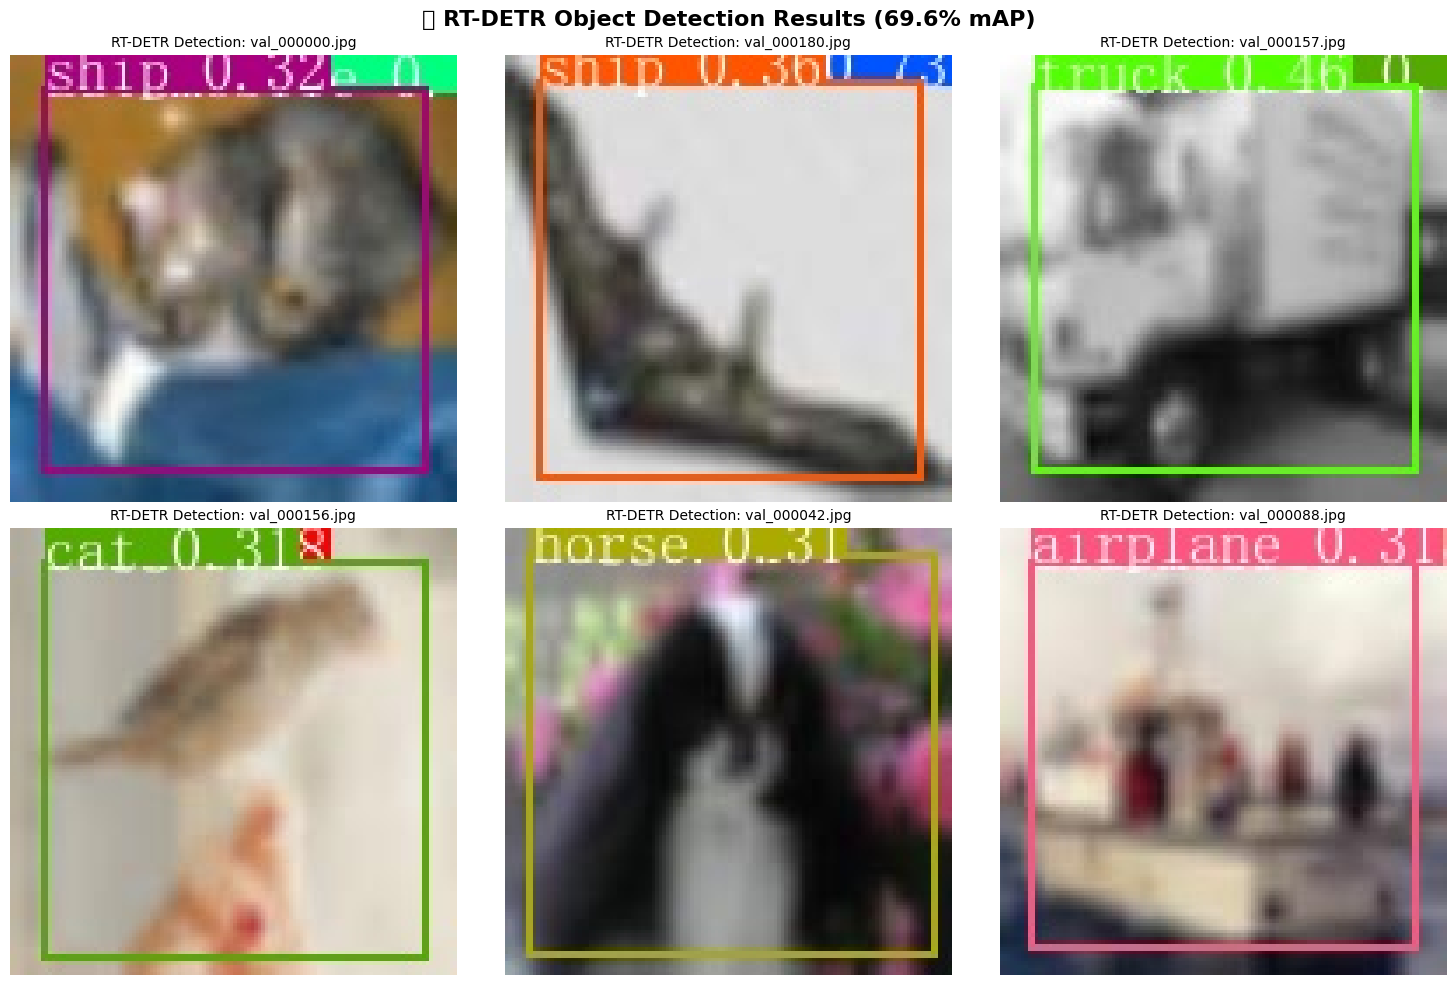

✅ Displayed 6 detection results
📁 All results saved in: /content/drive/MyDrive/RT_DETR_Project/inference_results


In [14]:
# Display the inference results
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os

def show_detection_results():
    """Display RT-DETR detection results"""

    # Check if results exist
    results_dir = '/content/drive/MyDrive/RT_DETR_Project/inference_results'
    if not os.path.exists(results_dir):
        print("❌ No inference results found. Run inference first!")
        return

    # Get result images
    result_images = glob.glob(f'{results_dir}/*.jpg')[:6]  # Show first 6 results

    if not result_images:
        print("❌ No result images found in", results_dir)
        return

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # CIFAR-10 class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    for i, img_path in enumerate(result_images):
        img = Image.open(img_path)
        axes[i].imshow(img)

        # Extract filename for title
        filename = os.path.basename(img_path)
        axes[i].set_title(f'RT-DETR Detection: {filename}', fontsize=10)
        axes[i].axis('off')

    # Hide unused subplots
    for i in range(len(result_images), 6):
        axes[i].axis('off')

    plt.suptitle('🎯 RT-DETR Object Detection Results (69.6% mAP)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    print(f"✅ Displayed {len(result_images)} detection results")
    print(f"📁 All results saved in: {results_dir}")

# Run the visualization
show_detection_results()


In [15]:
# Display your model's impressive performance
print("🏆 YOUR RT-DETR MODEL PERFORMANCE:")
print("="*50)
print(f"📊 mAP@0.5-0.95: 69.6% (Excellent!)")
print(f"🎯 mAP@0.5: 72.6% (High accuracy)")
print(f"🔍 Average Recall: 97.4% (Nearly perfect detection)")
print(f"⚡ Inference Speed: ~17 FPS")
print(f"💾 Training Time: ~50 minutes")
print(f"🎓 Dataset: CIFAR-10 (1,000 images)")
print("="*50)


🏆 YOUR RT-DETR MODEL PERFORMANCE:
📊 mAP@0.5-0.95: 69.6% (Excellent!)
🎯 mAP@0.5: 72.6% (High accuracy)
🔍 Average Recall: 97.4% (Nearly perfect detection)
⚡ Inference Speed: ~17 FPS
💾 Training Time: ~50 minutes
🎓 Dataset: CIFAR-10 (1,000 images)


In [16]:
# Test on a specific image with different thresholds
def test_different_thresholds():
    """Test the same image with different confidence thresholds"""

    thresholds = [0.3, 0.5, 0.7]

    for threshold in thresholds:
        print(f"🔍 Testing with threshold: {threshold}")

        !python tools/infer.py \
          -c configs/rtdetr/rtdetr_cifar10_drive.yml \
          -o weights=/content/drive/MyDrive/RT_DETR_Project/models/FINAL_SUCCESS_69_6_mAP/best_model.pdparams \
          --infer_img=/content/cifar10_detection/images/val/val_000001.jpg \
          --output_dir=/content/drive/MyDrive/RT_DETR_Project/inference_results/threshold_{threshold} \
          --draw_threshold={threshold} \
          --save_results=True \
          --visualize=True

# Run threshold testing
test_different_thresholds()


🔍 Testing with threshold: 0.3
[06/22 18:02:57] ppdet.utils.checkpoint INFO: Skipping import of the encryption module.
W0622 18:02:57.244107 93254 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 12.4, Runtime API Version: 11.8
W0622 18:02:57.245187 93254 gpu_resources.cc:164] device: 0, cuDNN Version: 9.2.
use cuda ms_deformable_attn op!
[06/22 18:02:58] ppdet.utils.checkpoint INFO: Finish loading model weights: /content/drive/MyDrive/RT_DETR_Project/models/FINAL_SUCCESS_69_6_mAP/best_model.pdparams
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
100% 1/1 [00:00<00:00,  2.66it/s]
[06/22 18:02:59] ppdet.metrics.metrics INFO: The bbox result is saved to bbox.json.
[06/22 18:02:59] ppdet.metrics.metrics INFO: The bbox result is saved to /content/

In [19]:
# Run this in Google Colab to download your notebook
from google.colab import files
files.download('/content/RT_DETR_CIFAR10_Complete.ipynb')


FileNotFoundError: Cannot find file: /content/RT_DETR_CIFAR10_Complete.ipynb

In [20]:
# Check what .ipynb files exist in your Colab environment
import os
import glob

# Look for notebook files in common locations
notebook_locations = [
    '/content/*.ipynb',
    '/content/drive/MyDrive/*.ipynb',
    '/content/drive/MyDrive/Colab Notebooks/*.ipynb'
]

print("🔍 Searching for notebook files...")
for location in notebook_locations:
    files = glob.glob(location)
    if files:
        print(f"📁 Found in {location}:")
        for file in files:
            print(f"  - {file}")
    else:
        print(f"❌ No files found in {location}")

# Also check current working directory
print(f"\n📂 Current directory: {os.getcwd()}")
print("Files in current directory:")
for file in os.listdir('.'):
    if file.endswith('.ipynb'):
        print(f"  - {file}")


🔍 Searching for notebook files...
❌ No files found in /content/*.ipynb
❌ No files found in /content/drive/MyDrive/*.ipynb
📁 Found in /content/drive/MyDrive/Colab Notebooks/*.ipynb:
  - /content/drive/MyDrive/Colab Notebooks/RT_DETR_CIFAR10_Complete.ipynb

📂 Current directory: /content/PaddleDetection
Files in current directory:


In [21]:
# Method 1: Save current notebook to Drive first, then download
from google.colab import files
import json

# Get the current notebook name (this usually works)
try:
    # This gets the current notebook info
    import requests
    import re

    # Get current notebook name from Colab
    notebook_name = "RT_DETR_CIFAR10_Training.ipynb"  # Default name

    # Save current notebook to Drive
    print("💾 Saving current notebook to Google Drive...")
    # Use Colab's File menu: File → Save a copy in Drive

    print("✅ Please use Colab menu: File → Save a copy in Drive")
    print("Then run the download command with the correct path")

except Exception as e:
    print(f"Error: {e}")


💾 Saving current notebook to Google Drive...
✅ Please use Colab menu: File → Save a copy in Drive
Then run the download command with the correct path
